<a href="https://colab.research.google.com/github/MattiaVerticchio/PersonalProjects/blob/master/MarketForecasting/TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Forecasting

> **Abstract**
>
> This project focuses on forecasting market indices from time-series, over a 43 market days horizon. The dataset contains six columns for different world zones MSCI indices: North America, Europe, Emerging Markets, Pacific area, European Monetary Union, and Developed World. The data span four years. The framework used for the task is H2O.ai Driverless AI, executed on Google Colab.

## Introduction
The objective of this project is the prediction of future market indices. The dataset covers six indices and four years. The indices are the following:
- MSCI Emerging Markets
- MSCI European Economic and Monetary Union
- MSCI Europe 
- MSCI North America
- MSCI Pacific
- MSCI World

We’ll test the model on the last 43 market days of the dataset, trying to predict them.
The metric is the Mean Absolute Percentage Error, defined as follows:

$$ \text{MAPE}=\frac{1}{n}\sum_{i=1}^{n} \left| \frac{Y_i - y_i}{Y_i} \right|\cdot 100$$

- $Y$ is the actual value of the index price
- $y$ is the model’s forecast
- $n$ is the forecasting horizon of 43 days.

H2O.ai Driverless AI optimizes the training pipeline via genetic evolution.
The models tested are the following:
- Decision Tree
- XGBoost Gradient Boosting Model
- XGBoost DART
- Microsoft LightGBM
- TensorFlow
- PyTorch
- FTRL
- RuleFit
- Zero-inflated model

### Notebook setup
The first thing to do is to install the Driverless AI Python client, downloadable directly from [inside the software](http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/python_install_client.html).

In [ ]:
pip install -q h2oai_client-1.9.0.4-py3-none-any.whl

Now we import the libraries.

In [ ]:
import pandas as pd                             # DataFrame
import seaborn as sns                           # Plotting library
from h2oai_client import Client                 # Driverless AI Python Client

%config InlineBackend.figure_format = 'retina'  # High resolution plots
sns.set(rc={'figure.figsize': (13, 5)})         # Plot size
sns.set_style('ticks')                          # Plotting style

### Reading the data
We can download the data from [MSCI’s official page](https://www.msci.com/end-of-day-data-search), then import it in Pandas from a local file.

> _Note: This repository doesn’t contain the dataset due to copyright limitations from MSCI._

In [ ]:
df = pd.read_excel(       # Reading the Excel file
    'Index History.xls',  # File to read
    index_col='Date',     # Column to set as index
    skiprows=6,           # Skipping the first rows
    skipfooter=18         # Skipping the last rows
    )

df.columns = [            # Setting the column names
    'Emerging Markets',   # MSCI Emerging Markets Index
    'EMU',                # MSCI EMU Index
    'Europe',             # MSCI Europe Index
    'North America',      # MSCI North America Index
    'Pacific',            # MSCI Pacific Index
    'World'               # MSCI World
    ]
              
df.tail()                 # Print the last 5 rows

,Emerging Markets,EMU,Europe,North America,Pacific,World
Date,,,,,,
2020-10-01,1084.835,187.960,1600.032,3421.987,2666.986,2380.021
2020-10-02,1081.706,187.628,1601.383,3389.198,2646.523,2362.406
2020-10-05,1091.381,190.940,1625.214,3450.733,2690.586,2403.500
2020-10-06,1102.470,191.748,1626.057,3404.210,2704.529,2382.570
2020-10-07,1107.899,191.287,1620.024,3462.703,2705.295,2409.395


We can visualize the returns of the indexes since 7 October 2016.

The most performing is the MSCI North America Index, followed by MSCI World, which content overlaps for a substantial portion with the first one.

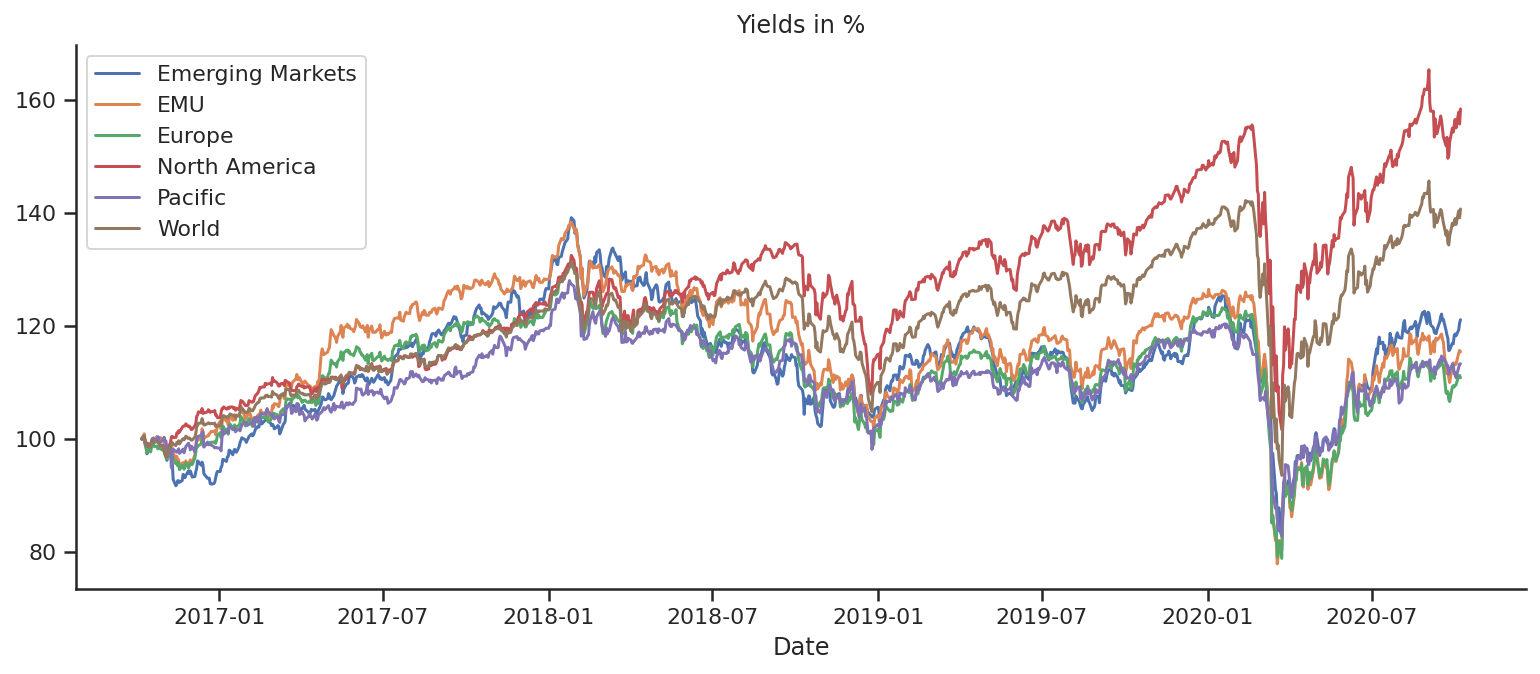

In [ ]:
sns.lineplot(                     # Plot the indeces
    data=df.div(df.iloc[0])*100,  # Returns normalized
    dashes=False,                 # Set continuous lines only
).set_title('Yields in %');

sns.despine();                    # Remove the top and right bars

Now we can prepare the dataset for training.

In [ ]:
df['Date'] = df.index                     # Create a date column

dataset = pd.melt(                        # Convert DataFrame to long form
    df,                                   # Data
    id_vars='Date',                       # Variable to set as index
    value_name='Price',                   # Target value
    var_name='Index')                     # Index name as categorical variable

dataset = dataset.sort_values(by=['Date', 'Index'])  # Sort by date and index
dataset = dataset.set_index(['Date', 'Index'])            # Reset the index

dataset.tail(6)                           # Print the last six rows

Price
Date       Index                     
2020-10-07 EMU                191.287
           Emerging Markets  1107.899
           Europe            1620.024
           North America     3462.703
           Pacific           2705.295
           World             2409.395

Let’s split the dataset into training and testing subsets, then save them.

In [ ]:
train_data = dataset.loc[:'2020-08-10']  # Split training data
test_data = dataset.loc['2020-08-11':]   # Split testing data

train_data.to_csv('train.csv')      # Save training data
test_data.to_csv('test.csv')        # Save testing data

## Training the model
At this point we can start the training process. First, we can initialize the Driverless AI Python client.

In [ ]:
h2oai = Client(                              # Initializing client
    address='https://url_of_driverless_ai',  # Address of instance
    username='h2oai',                        # Standard username
    password='h2oai'                         # Standard password
    )

Then we load the data.

In [ ]:
train_dai = h2oai.upload_dataset_sync('train.csv')  # Load the training set
test_dai = h2oai.upload_dataset_sync('test.csv')    # Load the testing set

Here we configure the experiment settings and start the training.

In addition to the code settings, I loaded other transformers and models:
- Auto-ARIMA models
- Exponential Weighted Moving Average
- Time series volatility

Driverless AI will start its genetic pipeline optimization a return a fitted model

In [ ]:
experiment = h2oai.start_experiment_sync(     # Driverless AI experiment
    dataset_key=train_dai.key,                # Training set 
    testset_key=test_dai.key,                 # Testing set
    target_col='Price',                       # Column to predict
    is_classification=False,                  # It's a regression problem
    is_time_series=True,                      # Enable time series mode
    accuracy=10,                              # Arbitrary accuracy
    time=4,                                   # Time limit
    interpretability=1,                       # To use all the models
    scorer='RMSE',                            # Root Mean Square Error
    enable_gpus=True,                         # Use hardware acceleration
    time_groups_columns=['Index'],            # Group data by index
    seed=42,                                  # To reproduce the experiment
    time_col='Date',                          # Time column
    num_prediction_periods = len(test_data),  # Predict on the test set
    num_gap_periods=0,                        # No gaps between train and test
    config_overrides="""
        enable_decision_tree='on'           
        enable_xgboost_gbm='on'
        enable_xgboost_dart='on'
        enable_lightgbm='on'
        enable_tensorflow='on'
        enable_pytorch='on'
        enable_ftrl='on'
        enable_rulefit='on'
        enable_zero_inflated_models='on'
        enable_custom_recipes=true
    """)

We can take a look at the best pipeline found.

### Feature engineering
There are 30 features engineered for training:
- Index price lags
- Exponential Weighted Moving Averages of the indices
- Sum, mean, median, maximum, minimum values and standard deviations of the aggregate indices
- Indices interactions and differentiation
- Indices skewness and kurtosis

### Model search
The model searched are:
- Microsoft LightGBM
- RuleFit
- Follow the Regularized Leader
- TensorFlow
and the best one is the LightGBM one.

Detailed information about the features and the pipeline are in the experiment report.

## Results

Let’s examine the results now, they are stored in a local `results.csv` file.

In [ ]:
df = pd.read_csv(          # Read the results CSV
    'results.csv',         # Local file
    parse_dates=['Date'],  # Set 'Date' as time column
    header=0,              # Set first row as header
    names=[                # Rename the columns
        'Date',
        'Index',
        'Price',
        'Prediction',
        'Lower',
        'Upper'
        ]
    )

# Creating new dataframe for actual data
df_actual = df[['Date', 'Index', 'Price']]

# Adding lower and upper bounds equal to index
df_actual = pd.concat([df_actual]*3, ignore_index=True)

# Sort by index and date
df_actual = df_actual.sort_values(['Date', 'Index'], ascending=[True, True])

# Creating new dataframe for prediction
df_pred = df[['Date', 'Index', 'Prediction', 'Lower', 'Upper']]

df_pred = df_pred.melt(         # Convert to long format
    id_vars=['Date', 'Index'],  # Date and Index as id variables
    value_name='Forecast').drop(columns='variable')
df_pred = df_pred.sort_values(['Date', 'Index', 'Forecast'], ascending=[True, True, True])

In [ ]:
# Creating the final results DataFrame
results = df_actual 
results['Forecast'] = df_pred['Forecast']
results = results.melt(id_vars=['Date', 'Index'], var_name='Type', value_name='USD')
results = results.sort_values(['Date', 'Index', 'Type'], ascending=[True, True, True]).set_index('Date')

### Plotting the results

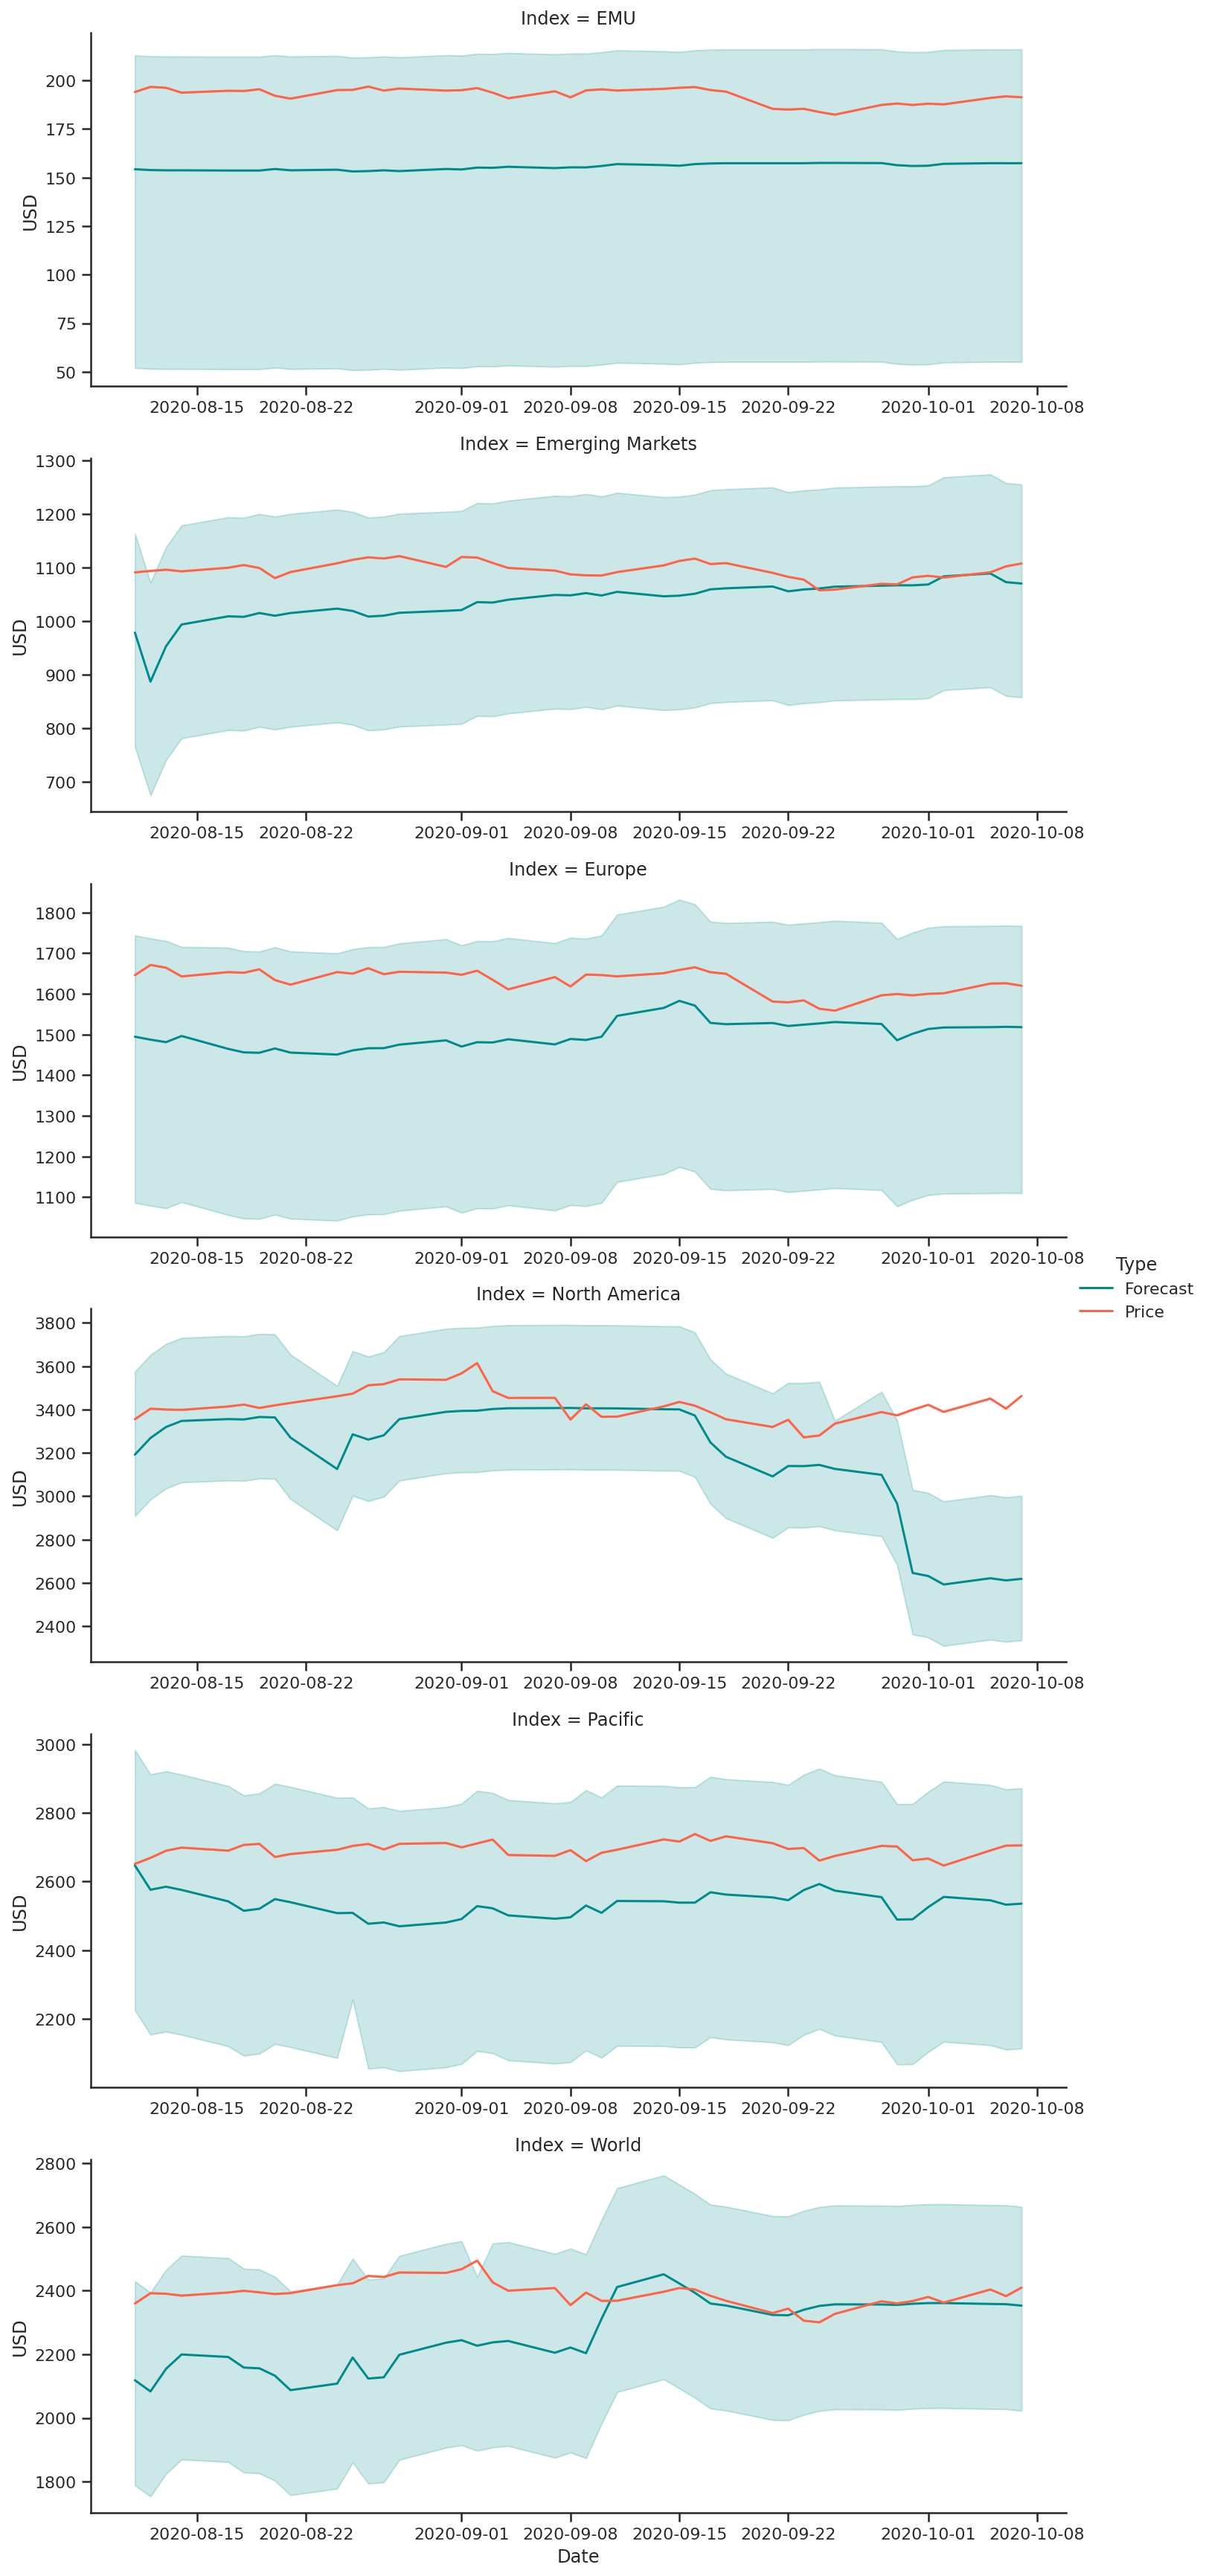

In [ ]:
sns.relplot(data=results, x='Date', y='USD', kind='line', row='Index',
            hue='Type', height=4, aspect=2.5, palette=['darkcyan', 'tomato'],
            facet_kws=dict(sharey=False, sharex=False));

### Mean Absolute Percentage Error

Given the results, we can compute the percentual deviation from the actual indices.

In [ ]:
MAPE = pd.DataFrame(columns=['Index', 'MAPE'])
for index in df.Index.unique():
    deviation = df[df.Index == index]['Price'] - df[df.Index == index]['Prediction']
    percent_dev = deviation/df[df.Index == index]['Price']
    MAPE = MAPE.append({
        'Index': index,
        'MAPE': percent_dev.abs().mean() *100},
        ignore_index=True)
    
MAPE = MAPE.append({
    'Index': 'Average',
    'MAPE': MAPE.MAPE.mean()}, 
    ignore_index=True)

MAPE = MAPE.set_index('Index')
MAPE.round(decimals=2)

,MAPE
Index,
EMU,3.60
Emerging Markets,3.84
Europe,2.81
North America,9.49
Pacific,2.94
World,5.29
Average,4.66


## Conclusion
The Microsoft LightGBM forecasting model was able to predict the chosen indeces within an average 5% deviation.

How could we furtherly improve this results?

1. Transform the indices to stationary time series and try to predict them, or augment the current data.
1. Update the dataset extending the period covered by observations. Some indices cover decades, while the available dataset covers 4 years only. If needed we can adjust the training data for inflation over the observations time-frame.
1. Increasing sampling frequency, adding intraday asset data and after hours prices, if available.
1. Disaggregate the index compositions.
1. Introduce more assets or exogenous features that can impact the prediction, like macroeconomic indicators and notable events.
1. Augment the dataset using signal processing metrics: cross-covariance, cross-correlation, Granger causality test and furtherly explore feature interaction.
1. Introduce a Natural Language Processing component based on news streams and financial docs, like SEC filings and analysts’ predictions.

[**Go back to index >**](https://github.com/MattiaVerticchio/PersonalProjects/blob/master/README.md)
